# Natural Language Processing

## Part 4: TorchText + biGRU + Attention + Masking + Padded + Teaching Forcing + BLEU

In this notebook we will be adding a few improvements - packed padded sequences and masking.  Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

The figures are from https://github.com/bentrevett.

**Note**: Skip to the model part.

In [1]:
!nvidia-smi

Mon Mar  6 10:52:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:84:00.0 Off |                  N/A |
| 24%   31C    P8    23W / 250W |    969MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 22%   

In [2]:
import numpy as np
import pandas as pd
from io import StringIO

In [8]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:3


In [9]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [10]:
torch.__version__

'1.13.1+cu117'

In [11]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [12]:
import gzip



with gzip.open("en-ne.txt.gz", mode="rt") as f:
    file_content = f.read()
    # print(file_content)

In [13]:
# \t \n
# file_content

In [14]:
file_content = file_content.replace("\r", "")

In [15]:
df = pd.read_csv(StringIO(file_content),sep='\t|\n',header=None)

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [16]:
df.head()

,0,1
0,York is a collegiate university and every stud...,न्यूयोर्क एक collegiate विश्वविद्यालय छ र हरेक...
1,40:8 All my enemies were whispering against me...,40:8 मेरो सबै शत्रुलाई मेरो विरुद्धमा कानेखुसी...
2,During the Presidency of Edmund J . James (190...,"पुस्तकालय, जसमा स्कूल संग खोलियो 1868, सुरु 1,..."
3,These sequences are intercepted by the ANSI.SY...,यी दृश्यहरु पीसी गरेको एक नम्बर मा CONFIG.SYS ...
4,"Do all my brothers, sisters, disillusioned, an...","मेरा सबै भाइहरूलाई के, बहिनीहरू, रनभुल्लमा, र ..."


In [17]:
df.size

184168

In [18]:

# total of 92084 pairs
df.shape

(92084, 2)

In [19]:
df2 = df.rename({0: 'eng', 1: 'nep'}, axis=1)

In [20]:
df2.head()

,eng,nep
0,York is a collegiate university and every stud...,न्यूयोर्क एक collegiate विश्वविद्यालय छ र हरेक...
1,40:8 All my enemies were whispering against me...,40:8 मेरो सबै शत्रुलाई मेरो विरुद्धमा कानेखुसी...
2,During the Presidency of Edmund J . James (190...,"पुस्तकालय, जसमा स्कूल संग खोलियो 1868, सुरु 1,..."
3,These sequences are intercepted by the ANSI.SY...,यी दृश्यहरु पीसी गरेको एक नम्बर मा CONFIG.SYS ...
4,"Do all my brothers, sisters, disillusioned, an...","मेरा सबै भाइहरूलाई के, बहिनीहरू, रनभुल्लमा, र ..."


In [21]:
columns_titles = ["nep","eng"]
df2=df2.reindex(columns=columns_titles)

In [22]:
df2.head()

,nep,eng
0,न्यूयोर्क एक collegiate विश्वविद्यालय छ र हरेक...,York is a collegiate university and every stud...
1,40:8 मेरो सबै शत्रुलाई मेरो विरुद्धमा कानेखुसी...,40:8 All my enemies were whispering against me...
2,"पुस्तकालय, जसमा स्कूल संग खोलियो 1868, सुरु 1,...",During the Presidency of Edmund J . James (190...
3,यी दृश्यहरु पीसी गरेको एक नम्बर मा CONFIG.SYS ...,These sequences are intercepted by the ANSI.SY...
4,"मेरा सबै भाइहरूलाई के, बहिनीहरू, रनभुल्लमा, र ...","Do all my brothers, sisters, disillusioned, an..."


In [23]:
# #uncomment this if you are not using our department puffer
# import os
# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# from torchtext.datasets import Multi30k

# SRC_LANGUAGE = 'en'
# TRG_LANGUAGE = 'de'

# train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [24]:
# #so this is a datapipe object; very similar to pytorch dataset version 2 which is better
# train

## 2. EDA - simple investigation

In [25]:
#let's take a look at one example of train
# sample = next(iter(_lo)
# sample

In [26]:
# train_size = len(list(iter(train)))
# train_size

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2,random_state=999)

In [28]:
len(train),len(test)

(73667, 18417)

In [29]:
train_data, val_data =  train_test_split(train, test_size=0.3,random_state=999)

In [30]:
len(train_data),len(val_data),len(test)

(51566, 22101, 18417)

In [31]:
train_data

,nep,eng
4695,समय प्रति समय सेवाको रूपरेखा बदलिइरहेको छ र बद...,You just have to know how to use it. You need ...
91116,बिरामी anointing को अभ्यास प्रेषितहरूको जस्तै ...,The practice of anointing the sick was an offi...
19345,अमेरिकामा पारस खड्का सहित ८ नेपाली क्रिकेटर Wi...,Nepal Rhinos face MSM England in 2X-Cricket Cu...
72367,115 पछिल्लो पिउनुपर्छ पानी सेवा गर्दै एक विषयम...,ON THE SUBJECT OF 115 THE ONE SERVING WATER SH...
55886,हामीलाई सम्पर्क गर्नुहोस: सम्पर्क[मा]binaryopt...,Contact us: contact [at] binaryoptionsindicato...
...,...,...
33234,10 पन्डुलिपी-कृष्ण धराबाशी | Listen and Download,Muktak Madhurima - 2069-10-11 | Listen And Dow...
71296,"a92a40g69b पाकिस्तान म हुं पुरुष, 31, खोज्दै म...","a92a40g69b Pakistan I am a man, 31, seeking a ..."
30894,"केचिनी एम ए, रूट डीई, रचउनव जेआर, र गेल्ब पी ए...","Cecchini MA, Root DE, Rachunow JR, and Gelb PM..."
77870,जाडो बिदा छोराको दिनमा 4 मार्च. 18:00 यो Allbe...,Before winter's day 4 March at. 18:00 it Allbe...


## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [32]:
# pip install -inltk -> for indian subcontinent languages
# https://www.analyticsvidhya.com/blog/2020/01/3-important-nlp-libraries-indian-languages-python/

In [33]:
# nepali language tokenizer -> nepalitokenizer
# pip install nepalitokenizer

In [34]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [35]:
from torchtext.data.utils import get_tokenizer
from nepalitokenizer import NepaliTokenizer

SRC_LANGUAGE= 'nep'
TRG_LANGUAGE= 'eng'

tokenize = NepaliTokenizer()

token_transform[SRC_LANGUAGE] = tokenize.tokenizer
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [36]:
# let's try tokenizing nepali language

tokenize = NepaliTokenizer()
print(tokenize.tokenizer('म तिमीलाई धेरै माया गर्छु मेरो प्रिय'))

['तिमीलाई', 'माया', 'प्रिय']


- Stop words also get removed
- Stop words are in this sentence -> म- I , धेरै - lots, गर्छु - do, मेरो - mine

https://github.com/xettrisomeman/tokenize/blob/main/src/nepalitokenizer.py

In [37]:
token_transform[SRC_LANGUAGE]('म तिमीलाई धेरै माया गर्छु मेरो प्रिय')

['तिमीलाई', 'माया', 'प्रिय']

In [38]:
#example of tokenization of the english part
# print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[TRG_LANGUAGE]('I love you very much my sweetheart'))

# stop words do not get removed here

Tokenization:  ['I', 'love', 'you', 'very', 'much', 'my', 'sweetheart']


A function to tokenize our input.

In [39]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [40]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [38]:
type(EOS_IDX)

int

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [42]:
yield_tokens(train_data, TRG_LANGUAGE)

<generator object yield_tokens at 0x7f48ccc2d660>

In [43]:
# build_vocab_from_iterator?

In [44]:
# making it iterable
# Note: The function build_vocab_from_iterator builds a vocab using a iterator only
# up until now, we have a dataframe so converting them to list
# makes it iterable

train_data = train_data.values.tolist()


In [45]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [46]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[299, 13, 11, 0, 11]

In [47]:
vocab_transform[SRC_LANGUAGE](['बिरामी', 'कार्यालय', 'तपाईं','माया'])

[1914, 262, 4, 2795]

In [48]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[3423]

'निकट'

In [49]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 1816, for example
mapping[999]

'Sun'

In [50]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [51]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [52]:
#check unique vocabularies
len(mapping)

48403

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [53]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 8

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [54]:
val_data = val_data.values.tolist()
test_data = test.values.tolist()

In [52]:
# sample_train = next(iter(train_data))
# sample_train

# sample_val = next(iter(val_data))
# sample_val

# sample_test = next(iter(test_data))
# sample_test

In [55]:
sample_train=[]
sample_val=[]
sample_test= []
for x,y in enumerate(train_data):
    #x - index
    if x == 5000:
        break
    sample_train.append(y)
    
for x,y in enumerate(val_data):
    #x - index
    if x == 4000:
        break
    sample_val.append(y)


for x,y in enumerate(test_data):
    #x - index
    if x == 3000:
        break
    sample_test.append(y)

In [56]:
batch_size = 8

sample_train_loader = DataLoader(sample_train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
sample_valid_loader = DataLoader(sample_val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
sample_test_loader  = DataLoader(sample_test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [57]:
batch_size = 8

train_loader = DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_data, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_data, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [58]:
for nep, _, eng in sample_train_loader:
    break

In [56]:
# for nep, _, eng in train_loader:
#     break

In [59]:
print("Nepali shape: ", nep.shape)  # (seq len, batch_size)
print("English shape: ", eng.shape)   # (seq len, batch_size)

Nepali shape:  torch.Size([47, 8])
English shape:  torch.Size([79, 8])


## 5. Design the model

### Encoder

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [60]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)        
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, hid dim * 2]
        #hidden = [batch size, hid dim]
        
        return outputs, hidden

### Attention

The attention used here is additive attention which is defined by:

$$e = v\text{tanh}(W_hh + W_ss + b)$$

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", `<pad>`, `<pad>`]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [61]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, hid dim]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
        #energy = [batch size, src len, hid dim]
        
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        
        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        
        return F.softmax(attention, dim = 1)

Let's see how the masked_fill work, just so you have faith

In [62]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [63]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
            
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        #this also means that output == hidden
        # assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Putting them together (become Seq2Seq!)

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [64]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so it's the same shape as attention
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attentiont outputs from decoder
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        mask = self.create_mask(src)
        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output    = [batch size, output dim]
            #hidden    = [batch size, hid dim]
            #attention = [batch size, src len]
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention for each token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

## 6. Training

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [65]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [66]:
device

device(type='cuda', index=3)

In [67]:
type(initialize_weights)

function

In [70]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(45155, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(48403, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=48403, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [72]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

11559680
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
12391168
1966080
786432
  1536
  1536
86738176
 48403
______
117171219


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [73]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [74]:
!nvidia-smi

Mon Mar  6 10:56:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:84:00.0 Off |                  N/A |
| 24%   31C    P8    23W / 250W |    969MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 22%   

In [75]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        
        #here?
        src = src.to(device).long()
        trg = trg.to(device).long()
        
        optimizer.zero_grad()
        
        # print('src',type(src))
        # print('trg', type(trg))
        # print('src_length' , type(src_length))
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [76]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device).long()
            trg = trg.to(device).long()

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [73]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [77]:
sample_train_loader_length = len(list(iter(sample_train_loader)))
sample_val_loader_length   = len(list(iter(sample_valid_loader)))
sample_test_loader_length  = len(list(iter(sample_test_loader)))

In [75]:
# type(sample_val_loader_length)

In [78]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

<!-- Reduced dataset -->
Epoch: 01 | Time: 1m 16s
	Train Loss: 6.007 | Train PPL: 406.258
	 Val. Loss: 6.296 |  Val. PPL: 542.175
Epoch: 02 | Time: 1m 16s
	Train Loss: 4.500 | Train PPL:  90.004
	 Val. Loss: 6.734 |  Val. PPL: 840.327
Epoch: 03 | Time: 1m 15s
	Train Loss: 3.416 | Train PPL:  30.442
	 Val. Loss: 6.951 |  Val. PPL: 1044.226
Epoch: 04 | Time: 1m 16s
	Train Loss: 2.909 | Train PPL:  18.347
	 Val. Loss: 7.089 |  Val. PPL: 1198.446
Epoch: 05 | Time: 1m 16s
	Train Loss: 2.618 | Train PPL:  13.709
	 Val. Loss: 7.132 |  Val. PPL: 1251.044
Epoch: 06 | Time: 1m 15s
	Train Loss: 2.298 | Train PPL:   9.954
	 Val. Loss: 7.246 |  Val. PPL: 1402.935
Epoch: 07 | Time: 1m 16s
	Train Loss: 2.091 | Train PPL:   8.096
	 Val. Loss: 7.366 |  Val. PPL: 1581.577
Epoch: 08 | Time: 1m 14s
	Train Loss: 1.850 | Train PPL:   6.358
	 Val. Loss: 7.556 |  Val. PPL: 1912.729
Epoch: 09 | Time: 1m 17s
	Train Loss: 1.621 | Train PPL:   5.060
	 Val. Loss: 7.757 |  Val. PPL: 2337.585
Epoch: 10 | Time: 1m 16s
	Train Loss: 1.464 | Train PPL:   4.325
	 Val. Loss: 7.814 |  Val. PPL: 2475.264

In [78]:
%%time
# print('asd')

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 19.6 µs


In [79]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()
    
    print(start_time)
    print('Inside training now.....')
    train_loss = train(model, sample_train_loader, optimizer, criterion, clip, sample_train_loader_length)
    print('Inside evaluation now.....')
    valid_loss = evaluate(model, sample_valid_loader, criterion, sample_val_loader_length)
    
    # train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    # valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    print(end_time)
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

1678100274.9830961
Inside training now.....
Inside evaluation now.....
1678100828.7265089
Epoch: 01 | Time: 9m 13s
	Train Loss: 7.502 | Train PPL: 1811.501
	 Val. Loss: 7.078 |  Val. PPL: 1186.006
1678100829.7035546
Inside training now.....
Inside evaluation now.....
1678101386.0598128
Epoch: 02 | Time: 9m 16s
	Train Loss: 6.644 | Train PPL: 767.819
	 Val. Loss: 6.971 |  Val. PPL: 1065.460
1678101389.155271
Inside training now.....
Inside evaluation now.....
1678101943.5346925
Epoch: 03 | Time: 9m 14s
	Train Loss: 6.075 | Train PPL: 434.639
	 Val. Loss: 6.954 |  Val. PPL: 1047.699
1678101947.0408313
Inside training now.....
Inside evaluation now.....
1678102510.1765926
Epoch: 04 | Time: 9m 23s
	Train Loss: 5.514 | Train PPL: 248.151
	 Val. Loss: 7.037 |  Val. PPL: 1138.340
1678102510.176953
Inside training now.....
Inside evaluation now.....
1678103066.9026668
Epoch: 05 | Time: 9m 16s
	Train Loss: 4.896 | Train PPL: 133.751
	 Val. Loss: 7.242 |  Val. PPL: 1396.403
1678103066.9030297
In

In [ ]:
!nvidia-smi

Text(0, 0.5, 'loss')

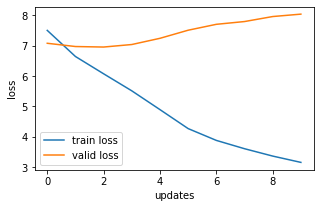

In [80]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Model is underfitting

In [82]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, sample_test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 42.834 | Test PPL: 4005338966564531200.000 |


In [83]:
model

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(45155, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(48403, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=48403, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 7. Test on some random phrases

In [178]:
random_text_src = 'म तिमीलाई धेरै माया गर्छु मेरो प्रिय'
random_text_trg = 'I love you very much'

In [179]:
src_text = text_transform[SRC_LANGUAGE](random_text_src).to(device)
src_text

tensor([   2,  807, 2795, 1978,    3], device='cuda:3')

In [180]:
trg_text = text_transform[TRG_LANGUAGE](random_text_trg).to(device)
trg_text

tensor([  2,  28, 447,  23, 168, 259,   3], device='cuda:3')

In [181]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [182]:
trg_text = trg_text.reshape(-1, 1)

In [183]:
src_text.shape, trg_text.shape

(torch.Size([5, 1]), torch.Size([7, 1]))

In [184]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [185]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [186]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([7, 1, 48403])

Since batch size is 1, we just take off that dimension

In [187]:
output = output.squeeze(1)

In [188]:
output.shape

torch.Size([7, 48403])

We shall remove the first token since it's zeroes anyway

In [189]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([6, 48403])

Then we just take the top token with highest probabilities

In [190]:
type(output[0]),type(output_max)

(torch.Tensor, torch.Tensor)

In [191]:
output.argmin(1)

tensor([10116,  8603,  8603,  8603, 39567, 39521], device='cuda:3')

In [192]:
output_max = output.argmax(1) #returns max indices

In [193]:
output_max

tensor([ 0, 44,  5,  5,  7,  5], device='cuda:3')

Get the mapping of the target language

In [194]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [196]:
for token in output.argmax(1):
    print(mapping[token.item()])

<unk>
And
the
the
of
the


In [197]:
for token in output_max:
    print(mapping[token.item()])

<unk>
And
the
the
of
the


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [198]:
attentions.shape

torch.Size([7, 1, 5])

In [199]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](random_text_src) + ['<eos>']
src_tokens

['<sos>', 'तिमीलाई', 'माया', 'प्रिय', '<eos>']

In [200]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', '<unk>', 'And', 'the', 'the', 'of', 'the']

In [201]:
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname='akshar.ttf', size=18)


def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45,fontproperties=font_prop)
        
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()

In [202]:
ax.set_fontproperties?


Object `ax.set_fontproperties` not found.


In [203]:
trg_tokens

['<sos>', '<unk>', 'And', 'the', 'the', 'of', 'the']

/tmp/ipykernel_20765/3653734894.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45,fontproperties=font_prop)
/tmp/ipykernel_20765/3653734894.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


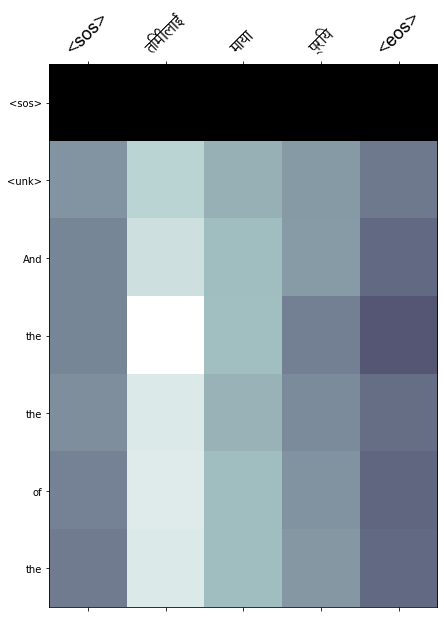

In [204]:
display_attention(src_tokens, trg_tokens, attentions)

## Conclusion

Nice!  We get the similar perplexity but with much faster computations, thanks to packed sequences and masking.   We also can see attention by our eyes, so we should believe it now!